In [1]:
#!/usr/bin/env python3
# -*- coding: utf-8 -*-
"""
Created on Mon Sep 24 21:52:30 2018

@author: whitneyreiner
"""
#Import packages
from sqlalchemy import create_engine
from sqlalchemy_utils import database_exists, create_database
import psycopg2
import numpy as np
import pandas as pd, matplotlib.pyplot as plt, time
from sklearn.cluster import DBSCAN
from geopy.distance import great_circle
from shapely.geometry import MultiPoint
from datetime import datetime as dt
import seaborn as sns
import hdbscan
from numpy import arccos, arcsin, around, cos, pi, radians, sin
%matplotlib inline

# Set your postgres username
dbname = 'postgres'
username = 'whitneyreiner' # change this to your username

# Connect to make queries using psycopg2
con = None
con = psycopg2.connect(database = dbname, user = username)
## 'engine' is a connection to a database
## Here, we're using postgres, but sqlalchemy can connect to other things too.
engine = create_engine('postgres://%s@localhost/%s'%(username,dbname))
print(engine.url)

# query:
sql_query = """
SELECT * FROM import.master1718random WHERE issueyear='2018'
LIMIT 100000;
"""
tickets_table_from_sql = pd.read_sql_query(sql_query,con)
tickets_table_from_sql

postgres://whitneyreiner@localhost/postgres


,ticketnumber,make,bodystyle,color,location,route,agency,violationcode,violationdescription,fineamount,issuetime,dt_issuednew,issuedatenew,issueyear,weekday,month,newlat,newlong,hour
0,4334821002,HOND,PA,BK,8827 HORNER ST,00141,51.0,80.69BS,NO PARK/STREET CLEAN,73.0,12:51:00,2018-06-18 12:51:00,2018-06-18,2018,0,6,34.05148128908458,-118.38479653214094,12
1,4325761812,TOYT,PA,GY,12066 VAN NUYS BLVD,00343,53.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:12:00,2018-03-08 08:12:00,2018-03-08,2018,3,3,34.28525673524164,-118.39581465414247,8
2,1125477905,KIA,PA,SI,813 HARVARD,00441,54.0,8069BS,NO PARK/STREET CLEAN,73.0,08:32:00,2018-01-24 08:32:00,2018-01-24,2018,2,1,34.057459857937886,-118.30416026704869,8
3,4336717136,FORD,VN,WT,3279 LEDGEWOOD DR,00410,54.0,22502A,18 IN. CURB/2 WAY,63.0,13:49:00,2018-07-17 13:49:00,2018-07-17,2018,1,7,34.12815739635027,-118.32190249484323,13
4,4335499615,VOLK,PA,BK,310 HELIOTROPE DR,00401,54.0,80.58L,PREFERENTIAL PARKING,68.0,02:00:00,2018-07-24 02:00:00,2018-07-24,2018,1,7,34.07645008228783,-118.29555820448894,2
5,4324696121,BMW,PA,BL,101 AVENUE 59 N,00610,56.0,88.13B+,METER EXP.,63.0,11:26:00,2018-01-13 11:26:00,2018-01-13,2018,5,1,34.1104729951214,-118.19099900596979,11
6,4338590561,CHEV,PA,BK,1700 IVAR AVE,00402,54.0,80.69B,NO PARKING,73.0,01:34:00,2018-08-27 01:34:00,2018-08-27,2018,0,8,34.10161300046551,-118.32816200069507,1
7,4332777923,BMW,PA,SL,201 BERENDO ST S,00400,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,12:20:00,2018-06-06 12:20:00,2018-06-06,2018,2,6,34.07086341472916,-118.29416093941047,12
8,4325290185,VOLK,PA,GY,1600 FORMOSA AVE N,401A,54.0,5200,DISPLAY OF PLATES,25.0,03:21:00,2018-02-13 03:21:00,2018-02-13,2018,1,2,34.09979400032568,-118.34676899969286,3
9,4337216984,HOND,PA,BK,7071 HAWTHORN AVE,00481,54.0,80.69BS,NO PARK/STREET CLEAN,73.0,12:44:00,2018-08-06 12:44:00,2018-08-06,2018,0,8,34.1003286693141,-118.34381599919479,12


In [2]:
tickets_table_from_sql['newlat'] = pd.to_numeric(tickets_table_from_sql['newlat'])
tickets_table_from_sql['newlong'] = pd.to_numeric(tickets_table_from_sql['newlong'])
tickets_table_from_sql['dt_issuednew'] = pd.to_datetime(tickets_table_from_sql['dt_issuednew'])
tickets_table_from_sql = tickets_table_from_sql[~tickets_table_from_sql['newlat'].isnull()] 
tickets_table_from_sql[['newlat','newlong']].isnull().sum()

newlat     0
newlong    0
dtype: int64

In [3]:
#training sample
#sample1= first 100k records in sql db from 2018
sample1=tickets_table_from_sql
sample1Coords = sample1[['newlat', 'newlong']]


In [4]:
clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=5, min_samples=6)
clusterer.fit(np.radians(sample1Coords))
clusterer.labels_

array([3643,   -1, 5154, ...,  897, 4744, 3569])

In [7]:
clusterer_labels = pd.DataFrame({'Cluster_no':clusterer.labels_})

In [8]:
clusterer.labels_.max()

6137

In [9]:
#clusterer_labels = pd.DataFrame({'Cluster_no':clusterer.labels_})
clusterer_labels['Cluster_no'].value_counts()[:1000]

-1       21311
 6001      191
 2818      141
 1005      140
 2817      135
 1880      126
 5255      116
 4363      115
 2474      107
 416       104
 1881      102
 25         99
 496        98
 40         92
 1928       84
 4662       83
 240        82
 1381       81
 3          81
 1862       79
 2305       78
 2515       78
 6081       75
 1380       74
 3609       73
 673        73
 1255       72
 6058       72
 5963       72
 305        70
         ...  
 478        18
 5579       18
 4990       18
 3150       18
 3449       18
 3453       18
 5707       18
 365        18
 3870       18
 1398       18
 2966       18
 1119       18
 1493       18
 2314       18
 4128       18
 5394       18
 5263       18
 4598       18
 4648       18
 5719       18
 5157       18
 2632       18
 6016       18
 5511       18
 2870       18
 745        18
 2780       18
 3268       18
 758        18
 4483       18
Name: Cluster_no, Length: 1000, dtype: int64

In [34]:
clusterer_probabilities = clusterer.probabilities_
clusterer_probabilities

array([0.23323615, 0.        , 0.        , ..., 0.88305639, 0.        ,
       1.        ])

In [16]:
clusterer_probabilities['Cluster_p'].value_counts()

1.000000    54634
0.000000    28379
0.232828        8
0.717391        8
0.274859        7
0.600000        7
0.600000        7
0.500000        7
0.205882        7
0.000009        7
0.528851        7
0.724156        7
0.750000        7
1.000000        7
1.000000        7
1.000000        6
1.000000        6
1.000000        6
0.777778        6
0.750000        6
0.665388        6
0.771074        6
0.972288        6
0.309679        6
0.686415        6
0.690909        6
0.167657        6
0.959485        6
0.566667        6
0.467094        6
            ...  
0.230769        1
0.631579        1
0.897016        1
0.339779        1
0.308576        1
0.402899        1
0.796636        1
0.789927        1
0.975786        1
0.466667        1
0.797066        1
0.285714        1
0.302515        1
0.366671        1
0.767645        1
0.960507        1
0.666667        1
0.695187        1
0.928385        1
1.000000        1
0.250000        1
0.817907        1
0.600000        1
0.834734        1
0.222222  

In [10]:

clusterer_probabilities = pd.DataFrame({'Cluster_p':clusterer.probabilities_})
dfclust = pd.concat([sample1, clusterer_labels, clusterer_probabilities], axis=1)
dfclust.describe()
# save to csv
#dfclust.to_csv('train_dfclustlabs_probs.csv', index=False, encoding='utf-8')

,newlat,newlong,Cluster_no,Cluster_p
count,100000.000000,100000.000000,100000.000000,100000.000000
mean,34.072148,-118.346965,2409.657960,0.650464
std,0.080109,0.090171,2034.497645,0.447454
min,33.706349,-118.660963,-1.000000,0.000000
25%,34.039561,-118.423548,242.000000,0.000000
50%,34.062340,-118.336099,2185.000000,1.000000
75%,34.102461,-118.274628,4237.000000,1.000000
max,34.327774,-118.160250,6137.000000,1.000000


In [36]:
#HDBSCAN
datacoor = dfclust[['newlat', 'newlong']].values
data = np.radians(datacoor)
#16 newlat
#17 newlong
#19 cluster_no
#20 cluster_p
data


array([[ 0.59487539, -2.06250918],
       [ 0.59483228, -2.06342706],
       [ 0.5948761 , -2.06443735],
       ...,
       [ 0.59663868, -2.06653988],
       [ 0.58884121, -2.06451341],
       [ 0.59440773, -2.06519446]])

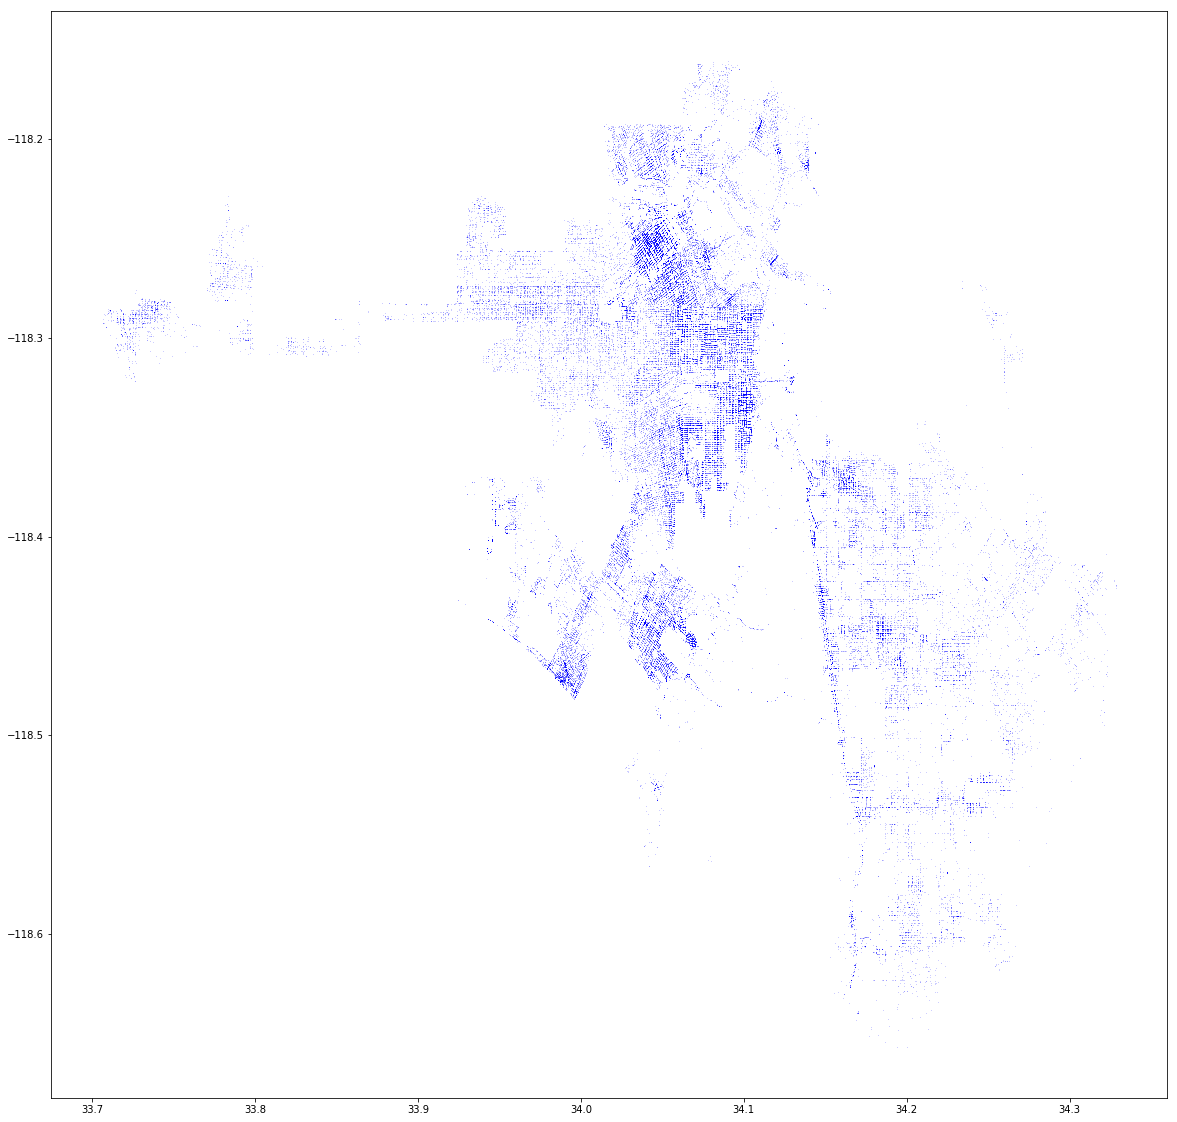

In [37]:
fig, ax = plt.subplots(figsize=[20, 20])
plt.scatter(*datacoor.T, s=1, linewidth=0, c='b', alpha=0.25)

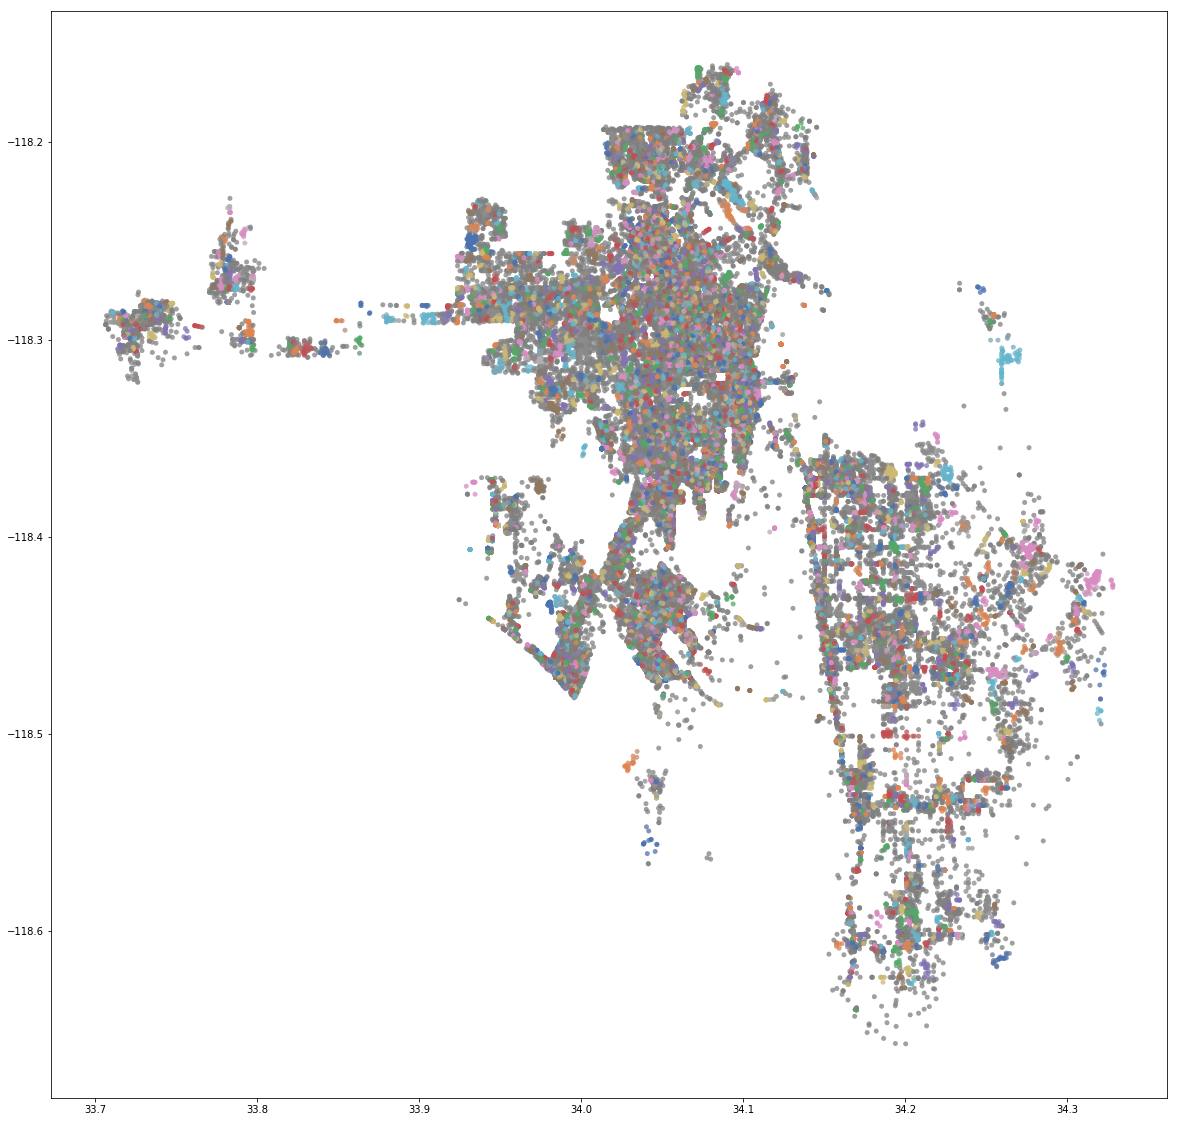

In [39]:
clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=5, min_samples=6)
clusterer.fit(np.radians(sample1Coords))

color_palette = sns.color_palette('deep', 6500)
cluster_colors = [color_palette[x] if x >= 0
                  else (0.5, 0.5, 0.5)
                  for x in clusterer.labels_]
cluster_member_colors = [sns.desaturate(x, p) for x, p in
                         zip(cluster_colors, clusterer.probabilities_)]
fig, ax = plt.subplots(figsize=[20, 20])
plt.scatter(*datacoor.T, s=25, linewidth=0, c=cluster_member_colors, alpha=0.75)


In [40]:
#extract the clusters
#sns.set_context('poster')
sns.set_style('white')
sns.set_color_codes()
plot_kwds = {'alpha' : 0.5, 's' : 25, 'linewidths':0}

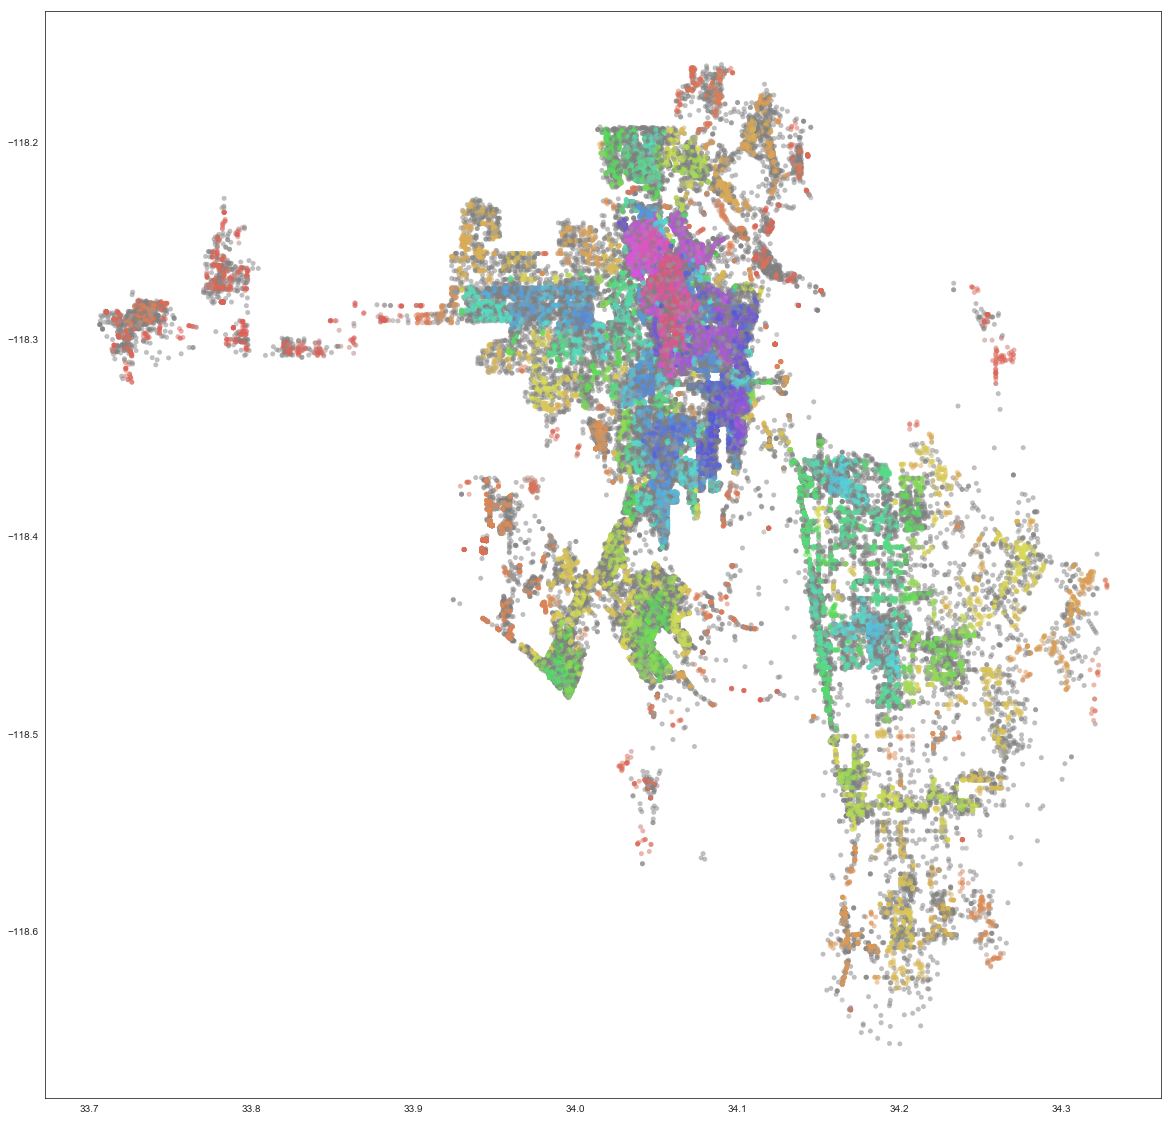

In [44]:
#clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=5, min_samples=6)
#clusterer.fit(np.radians(sample1Coords))

palette = sns.color_palette("hls", 6500)
cluster_colors = [sns.desaturate(palette[col], sat)
                  if col >= 0 else (0.5, 0.5, 0.5) for col, sat in
                  zip(clusterer.labels_, clusterer.probabilities_)]
fig, ax = plt.subplots(figsize=[20, 20])
plt.scatter(datacoor.T[0], datacoor.T[1], c=cluster_colors, **plot_kwds)


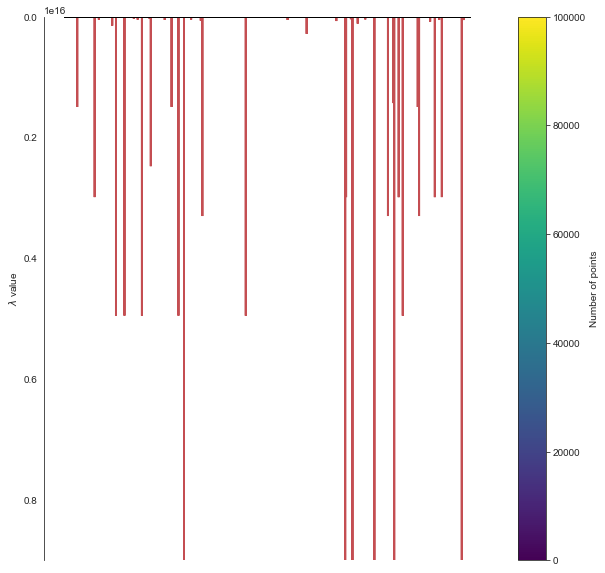

In [45]:
fig, ax = plt.subplots(figsize=[10, 10])
clusterer.condensed_tree_.plot(select_clusters=True, selection_palette=sns.color_palette())

In [ ]:
#Predicting new data

In [ ]:
#Use a test set- 35 from 2018

In [46]:
# query:
sql_query = """
SELECT *
FROM import.master1718random
WHERE issueyear='2018'
OFFSET 100000 ROWS
FETCH NEXT 100 ROWS ONLY
;

"""

testset_table_from_sql = pd.read_sql_query(sql_query,con)
testset_table_from_sql.head()


,ticketnumber,make,bodystyle,color,location,route,agency,violationcode,violationdescription,fineamount,issuetime,dt_issuednew,issuedatenew,issueyear,weekday,month,newlat,newlong,hour
0,4328155075,CHEV,PA,SL,6645 WOODMAN AVE,378R2,53.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:42:00,2018-03-19 08:42:00,2018-03-19,2018,0,3,34.191226334819994,-118.43125141233101,8
1,4323288303,CHRY,VN,OT,1200 GRANVILLE AV,00113,51.0,88.13B+,METER EXP.,63.0,11:38:00,2018-01-08 11:38:00,2018-01-08,2018,0,1,34.04803299712423,-118.46261899700693,11
2,4325647664,CHEV,PU,RD,3301 FITHIAN AVENUE,00600,56.0,5204A-,DISPLAY OF TABS,25.0,04:52:00,2018-02-07 04:52:00,2018-02-07,2018,2,2,34.08360100038806,-118.18004500022707,4
3,4323898176,KIA,PA,WT,1700 GULF AVE,00561,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:43:00,2018-01-08 08:43:00,2018-01-08,2018,0,1,33.79691003916659,-118.27426370455679,8
4,4324912642,MERZ,PA,SL,1301 ELECTRIC AVE,00409,51.0,88.13B+,METER EXP.,63.0,11:16:00,2018-01-19 11:16:00,2018-01-19,2018,4,1,33.99169100266036,-118.46790999864866,11


In [47]:
testset_table_from_sql.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 100 entries, 0 to 99
Data columns (total 19 columns):
ticketnumber            100 non-null object
make                    100 non-null object
bodystyle               100 non-null object
color                   100 non-null object
location                100 non-null object
route                   100 non-null object
agency                  100 non-null object
violationcode           100 non-null object
violationdescription    100 non-null object
fineamount              100 non-null object
issuetime               100 non-null object
dt_issuednew            100 non-null object
issuedatenew            100 non-null object
issueyear               100 non-null object
weekday                 100 non-null object
month                   100 non-null object
newlat                  100 non-null object
newlong                 100 non-null object
hour                    100 non-null object
dtypes: object(19)
memory usage: 14.9+ KB


In [49]:
#double check to make sure you queried correctly by looking for one of the ticket 
#numbers in this table in the training data table:
'4328155075' in tickets_table_from_sql.ticketnumber.values

False

In [50]:
testset_table_from_sql['newlat'] = pd.to_numeric(testset_table_from_sql['newlat'])
testset_table_from_sql['newlong'] = pd.to_numeric(testset_table_from_sql['newlong'])
testset_table_from_sql['dt_issuednew'] = pd.to_datetime(testset_table_from_sql['dt_issuednew'])
testset_table_from_sql = testset_table_from_sql[~testset_table_from_sql['newlat'].isnull()] 
testset_table_from_sql[['newlat','newlong']].isnull().sum()

newlat     0
newlong    0
dtype: int64

In [56]:
#test sample
#testsample=  35 records in sql db from 2018 STARTING AFTER record 100000 
testsample=testset_table_from_sql
testsampleCoords = testsample[['newlat', 'newlong']]
test_points = np.radians(test_points_coords)

In [263]:
#training data = datacoor

In [52]:
test_points_coords = testsampleCoords.values

(100, 2)

In [ ]:
#check the size 
test_points_coords.shape

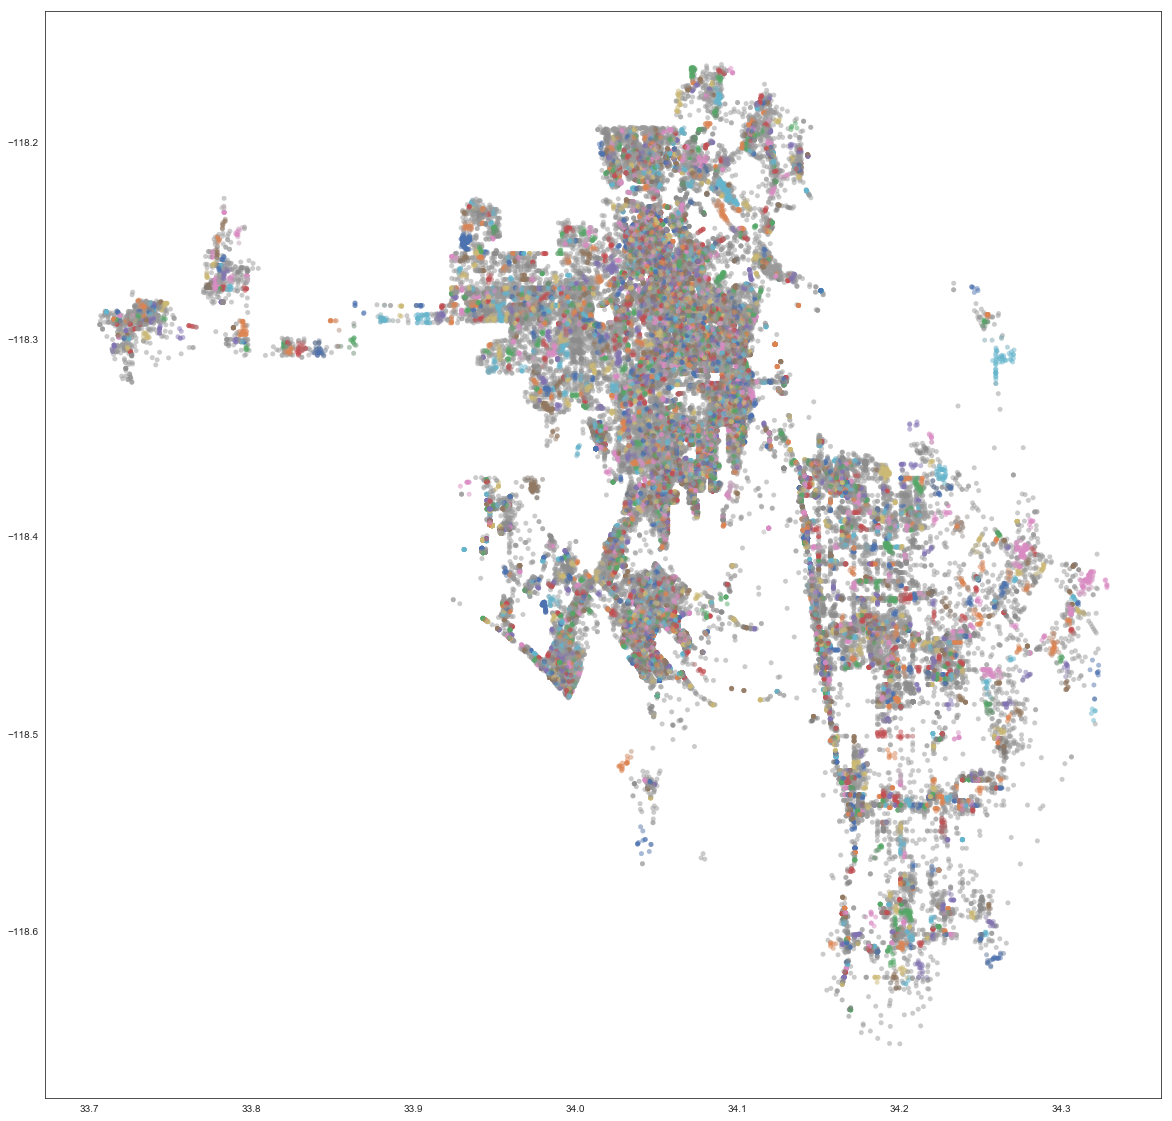

In [53]:
#set it up so it knows it is prediciton data
clusterer = hdbscan.HDBSCAN(metric='haversine', min_cluster_size=5, min_samples=6,prediction_data=True)
clusterer.fit(np.radians(sample1Coords))
pal = sns.color_palette('deep', 6500)
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
fig, ax = plt.subplots(figsize=[20, 20])
plt.scatter(datacoor.T[0], datacoor.T[1], c=colors, **plot_kwds);

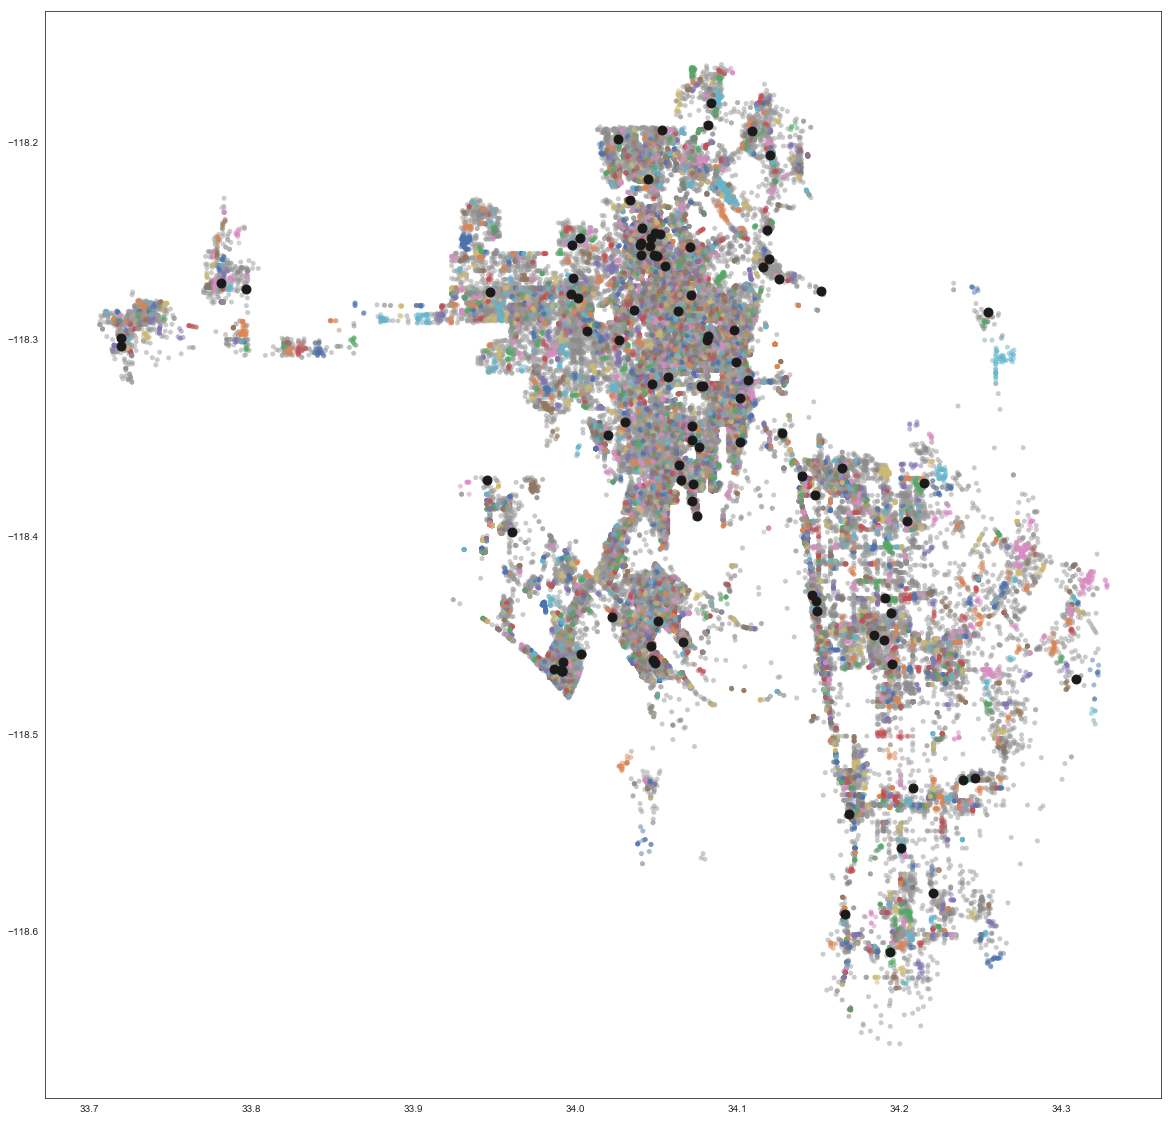

In [58]:
# MAKE SURE YOU ARE PLOTTING BOTH AS RADS OR BOTH AS COORDINATES!!!! OR IT WILL FUCK UP
test_points = np.radians(test_points_coords)
fig, ax = plt.subplots(figsize=[20, 20])
colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
#plt.ylim(-2.072, -2.060)                                                           
#plt.xlim(0.586, 0.601)
plt.scatter(datacoor.T[0], datacoor.T[1], c=colors, **plot_kwds);
plt.scatter(*test_points_coords.T, c='k', s=80)

In [59]:
test_labels, strengths = hdbscan.approximate_predict(clusterer, test_points)
test_labels

array([2587, 1729,   -1,   33, 2264, 1672,  191,   -1, 2453, 2846,   -1,
         -1,  486, 2392,   -1,   -1, 5560,   -1, 3164,   51, 2790, 3845,
         -1,   -1, 1641, 5306,  110, 3165,   -1, 2637,   -1,   -1,   -1,
         -1, 5425, 5535, 4980,   -1, 4655, 5845, 4633,   -1, 2949,   -1,
        681,  302,   -1,  554, 4386, 4063, 3273,   -1,   -1,  122, 3313,
       5530,   -1, 1146,   -1, 4791,  943,   -1, 2210, 3977, 1330, 1088,
       2710, 4559, 5698, 1777,   -1,   61, 2864, 5332,   -1, 3203,  145,
         -1,   -1,   -1,   -1, 2064,   -1,  872, 6047, 4093,  762, 2264,
       2582, 4872,   -1, 5050,  142, 5615,   -1, 2341,   -1, 2264, 2752,
         -1])

In [60]:
test_labelsdf = pd.DataFrame({'test_clust_no': test_labels})
test_labelsdf.head()

,test_clust_no
0,2587
1,1729
2,-1
3,33
4,2264


In [61]:
testSet_dfclust = pd.concat([testsample, test_labelsdf], axis=1)
testSet_dfclust.describe()
testSet_dfclust.head()
#save as csv

,ticketnumber,make,bodystyle,color,location,route,agency,violationcode,violationdescription,fineamount,issuetime,dt_issuednew,issuedatenew,issueyear,weekday,month,newlat,newlong,hour,test_clust_no
0,4328155075,CHEV,PA,SL,6645 WOODMAN AVE,378R2,53.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:42:00,2018-03-19 08:42:00,2018-03-19,2018,0,3,34.191226,-118.431251,8,2587
1,4323288303,CHRY,VN,OT,1200 GRANVILLE AV,00113,51.0,88.13B+,METER EXP.,63.0,11:38:00,2018-01-08 11:38:00,2018-01-08,2018,0,1,34.048033,-118.462619,11,1729
2,4325647664,CHEV,PU,RD,3301 FITHIAN AVENUE,00600,56.0,5204A-,DISPLAY OF TABS,25.0,04:52:00,2018-02-07 04:52:00,2018-02-07,2018,2,2,34.083601,-118.180045,4,-1
3,4323898176,KIA,PA,WT,1700 GULF AVE,00561,55.0,80.69BS,NO PARK/STREET CLEAN,73.0,08:43:00,2018-01-08 08:43:00,2018-01-08,2018,0,1,33.796910,-118.274264,8,33
4,4324912642,MERZ,PA,SL,1301 ELECTRIC AVE,00409,51.0,88.13B+,METER EXP.,63.0,11:16:00,2018-01-19 11:16:00,2018-01-19,2018,4,1,33.991691,-118.467910,11,2264


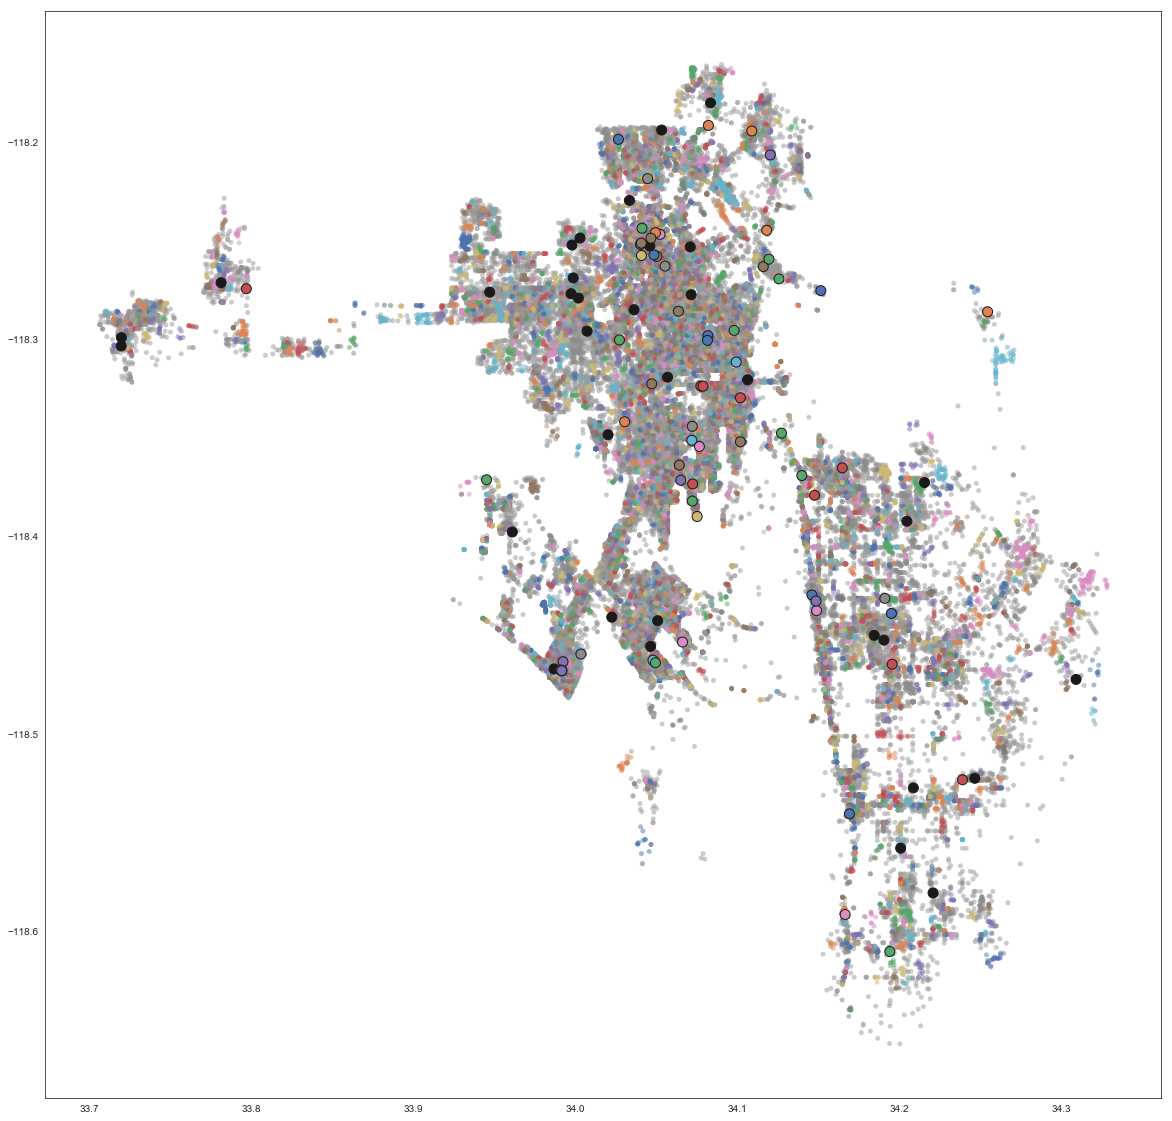

In [62]:
# MAKE SURE YOU ARE PLOTTING BOTH AS RADS OR BOTH AS COORDINATES!!!! OR IT WILL FUCK UP
fig, ax = plt.subplots(figsize=[20, 20])

colors = [sns.desaturate(pal[col], sat) for col, sat in zip(clusterer.labels_, clusterer.probabilities_)]
test_colors = [pal[col] if col >= 0 else (0.1, 0.1, 0.1) for col in test_labels]
plt.scatter(datacoor.T[0], datacoor.T[1], c=colors, **plot_kwds);
plt.scatter(*test_points_coords.T, c=test_colors, s=100, linewidths=1, edgecolors='k')


In [63]:
#save training lat and long coordinates
np.save('train_datacoor',datacoor)
#save training data radians
np.save('train_dataRadians',data)
#save clusterer_labels
np.save('train_clustLabs',clusterer.labels_)
#save clusterer_probabilities
np.save('train_clustProbs', clusterer.probabilities_)